*Curso: Big Data - Métodos Intensivos de Computación*</br>
*Presentado por: Boris Mauricio Martinez Gutierrez*

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/BigData/dask/

Mounted at /content/drive
/content/drive/MyDrive/BigData/dask


In [ ]:
# instala la version mas reciente de dask
!pip install distributed==2021.4.0

European Centre for Medium Range Weather Forecasts
----------------------------------------------------------

[Download script](https://gist.github.com/mrocklin/26d8323f9a8a6a75fce0)

Download historical global weather data from the ECMWF.

**Try the following:**

*  What is the variance in temperature over time?
*  What areas experienced the largest temperature swings in the last month relative to their previous history?
*  Plot the temperature of the earth as a function of latitude and then as longitude

In [ ]:
# directorio para el dataset ECMWF
import os

path = os.path.join('data','ECMWF')
if not os.path.exists(path):
  os.makedirs(path)

In [ ]:
# api de ecmwf
!pip install ecmwf-api-client

  Created wheel for ecmwf-api-client: filename=ecmwf_api_client-1.6.1-cp37-none-any.whl size=12619 sha256=fc245c398b433f4aacff413282f0f3c1147a751d152aaaf529341a3d0d17ffdd
  Stored in directory: /root/.cache/pip/wheels/5d/d0/c9/cef75ed33d0af19abb56f1df6b890ff3d8b7686cd240253800
Successfully built ecmwf-api-client


In [ ]:
# descarga los datos del servidor de ECMWF vía API. El dataset del clima corresponde al periodo: 2014-01-01 a 2014-12-31
import pandas as pd
from ecmwfapi import ECMWFDataServer

dates = pd.date_range('2014-01-01', '2014-12-31', freq='D')
dates = [str(d).split()[0] for d in dates]

# datos de autenticación del usario de la API y conexión con el servidor
url = "https://api.ecmwf.int/v1"
key = "21ce74e611858a481dfd38b77226b4f5"
email = "bomartinezg@unal.edu.co"

server = ECMWFDataServer(url=url, key=key, email=email)

for date in dates:
    server.retrieve({
      'stream'    : "oper",
      'levtype'   : "sfc",
      'param'     : "165.128/166.128/167.128",
      'dataset'   : "interim",
      'step'      : "00",
      'grid'      : "0.25/0.25",
      'time'      : "00/06/12/18",
      'date'      : date,
      'type'      : "an",
      'class'     : "ei",
      'target'    : os.path.join(path, date+'.nc3'),
      'format'    : "netcdf"
      })

Se han truncado las últimas 5000 líneas del flujo de salida.
mars - INFO   - 20210430.153431 - MARS Client package version: 6.28.6
mars - INFO   - 20210430.153431 - MARS Client build stamp: 20200717102127
mars - INFO   - 20210430.153431 - MIR version: 1.4.7
mars - INFO   - 20210430.153431 - Using ecCodes version 2.18.0
mars - INFO   - 20210430.153431 - Using odb_api version: 0.15.11 (file format version: 0.5)
mars - INFO   - 20210430.153431 - Using FDB5 version: 5.6.1
mars - INFO   - 20210430.153431 - Maximum retrieval size is 50.00 G
retrieve,stream=oper,levtype=sfc,param=165.128/166.128/167.128,padding=0,step=00,grid=0.25/0.25,expver=0001,time=00/06/12/18,date=2014-10-30,type=an,class=eimars - WARN   - 20210430.153431 - For full resolution grid, it is recommended to use RESOL=AV to prevent any truncation before transformation
mars - INFO   - 20210430.153431 - Automatic split by date is on

mars - INFO   - 20210430.153431 - Processing request 1
sh: /usr/bin/mailx: No such file or dire

In [ ]:
# tamaño en disco del dataset
!du -sh data/ECMWF

8.5G	data/ECMWF


In [ ]:
# el dataset está constituido por multiples archivos con formato netCDF. La libreria xarray facilita la lectura en paralelo de los archivos
!pip install netCDF4 xarray

     |████████████████████████████████| 4.7MB 8.9MB/s 
     |████████████████████████████████| 317kB 50.9MB/s 


In [ ]:
from dask.distributed import Client
client = Client()

In [ ]:
from glob import glob
import xarray as xa
import dask.array as da

filenames = sorted(glob(os.path.join(path, '*.nc3')))

def open_chunks(file):
  '''
  abre un archivo con formato netCDF que contine un dataset y extrae
  la variable de interés t2m (temperatura) y devuelve los datos como un array
  '''
  d = xa.open_dataset(file)
  return d.t2m.values

# lista con todos los array de la variable temperatura del dataset
da_list = [da.from_array(open_chunks(f)) for f in filenames]

x = da.stack(da_list, axis=0)
x

,Array,Chunk
Bytes,5.65 GiB,15.84 MiB
Shape,"(365, 4, 721, 1440)","(1, 4, 721, 1440)"
Count,730 Tasks,365 Chunks
Type,float32,numpy.ndarray


In [ ]:
# varianza de la temperatura en todo el periodo
%time x.var().compute()

CPU times: user 9.97 s, sys: 257 ms, total: 10.2 s
Wall time: 5.4 s


452.1858

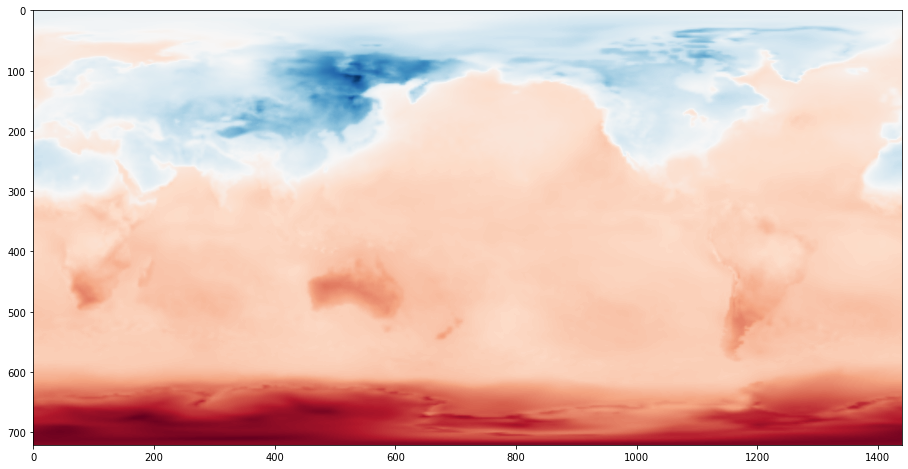

In [ ]:
# temperatura promedio en el mes de diciembre
last_month = x[-31:].mean(axis=0)
# temperatura promedio en los meses anteriores
historic = x[:-31].mean(axis=0)
# diferencia en temperatura
result = last_month - historic

%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(16, 8))
plt.imshow(result, cmap='RdBu_r');

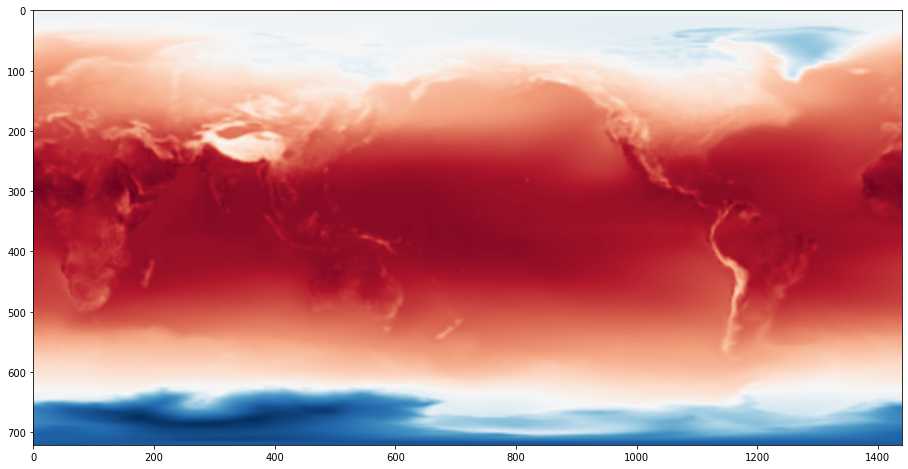

In [ ]:
# temperatura promedio de la tierra durante 2014
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(16, 8))
plt.imshow(x.mean(axis=0), cmap='RdBu_r');

In [ ]:
client.close()